In [17]:
%pylab inline

plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'Generator']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
import torch
from torch import nn
from torchvision.datasets import MNIST

from tqdm import tqdm_notebook as tqdm

In [0]:
mnist = MNIST('.', download=True)

In [20]:
class Data(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x.unsqueeze(1).float()
        self.y = y.long()
    def __getitem__(self, n):
        return self.x[n], self.y[n]

    def __len__(self):
        return self.y.shape[0]

def zscore(mnist, inpt_data):
    return (inpt_data - mnist.train_data.float().mean())/mnist.train_data.float().std()

train_data = zscore(mnist, mnist.train_data)
valid_data = zscore(mnist, mnist.test_data)

train = torch.utils.data.DataLoader(
    Data(
        train_data,
        mnist.train_labels
    ),
    batch_size=120, shuffle=True
    )

valid = Data(
    valid_data,
    mnist.test_labels
    )
valid[:9][0].shape

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.Size([9, 1, 28, 28])

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 64, 2, 1),
            nn.Conv2d(64, 128, 2, 1),
            nn.LeakyReLU(inplace=0.5),
            nn.BatchNorm2d(128)
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(128, 64, 2, 2),
            nn.Conv2d(64, 2, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(1)
        )

        self.fc = nn.Linear(72, 10)

    def forward(self, x):
        x =  self.conv0(x)
        x = self.conv1(x)
        # print(x.shape)
        x = torch.flatten(x,start_dim=1)
        return self.fc(x)

In [0]:
%%bash
if [ ! -f model.pth ]; then
    wget https://github.com/demacdolincoln/adversarial_talk/raw/master/model.pth
fi

In [0]:
model = torch.load('model.pth', map_location=torch.device('cpu')).eval()

In [24]:
model

Model(
  (conv0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(64, 2, kernel_size=(2, 2), stride=(2, 2))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=72, out_features=10, bias=True)
)

In [0]:
a = torch.randn(1, 1, 28, 28)

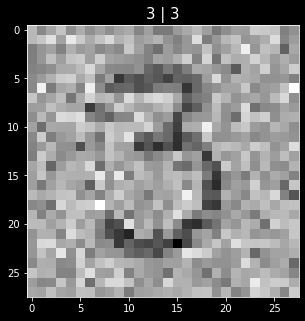

In [40]:
val, label = valid[50:51]
test = val + a

figsize(5, 5)
imshow(test.detach().squeeze().numpy(), cmap=cm.gray_r)
title(f"{model(test).argmax().item()} | {label.item()}", fontsize=15);

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv0 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 20, 3),
            torch.nn.Conv2d(20, 16, 2),
            torch.nn.Conv2d(16, 1, 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.BatchNorm2d(1)
        )
    def forward(self, x,y):
        out = self.conv0(x)
        out = torch.nn.functional.interpolate(out, 28)
        # return torch.relu(y * torch.sigmoid(out))
        # return y * torch.sigmoid(out)
        return torch.relu(y - out)


generator = Generator()

In [48]:
out = generator(a, val)
out.shape

torch.Size([1, 1, 28, 28])

In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-5)

In [50]:
p,v = model(generator(a, val)).argmax().item(), label.item()

pbar = tqdm(unit=' epochs')

while p == v:
    optimizer.zero_grad()

    out = generator(a, val)
    pred = model(out)
    loss = (1 - criterion(pred, label))
    loss.backward()
    optimizer.step()

    p = pred.argmax().item()

    pbar.set_description(f'{p} :{loss.item():.3f}', refresh=False)
    pbar.update()

pbar.close()

print('-'*80)
print(f'{p} : {loss.item():.3f}')


--------------------------------------------------------------------------------
5 : 0.279


In [0]:
t = generator(a, val)

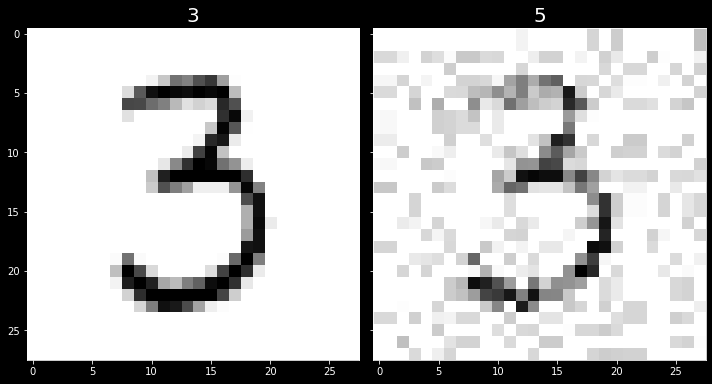

In [52]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 25), sharey=True)

ax0.imshow(val.detach().squeeze().numpy(), cmap=cm.gray_r)
ax0.set_title(model(val).argmax().item(), fontsize=20)

ax1.imshow(t.detach().squeeze().numpy(), cmap=cm.gray_r)
ax1.set_title(model(t).argmax().item(), fontsize=20)

fig.tight_layout();